# Prueba de los modelos

En este notebook se probarán los modelos entrenados (CNN y LSTM) sobre los datasets de prueba *"Getting Real About Fake News"* y *"Fake news detection"*.


## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install --upgrade pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)


In [3]:
!ls "drive/My Drive/Colab Notebooks/data"

data_kaggle_proc.pickle		       news_getting_real.pickle
GoogleNews-vectors-negative300.bin.gz  news_proc_12_3_19.pickle


In [0]:
import pandas as pd
import numpy as np

#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
#import swifter

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn')
import seaborn as sns

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [0]:
LSTM_PATH = 'drive/My Drive/Colab Notebooks/weights/lstm.h5'
CONV_PATH = 'drive/My Drive/Colab Notebooks/weights/conv.h5'

## Prepare data

In [0]:
getting_real = pd.read_pickle('drive/My Drive/Colab Notebooks/data/news_getting_real2.pickle')
true_or_fake = pd.read_pickle('drive/My Drive/Colab Notebooks/data/data_kaggle_proc.pickle')

In [127]:
getting_real.head(2)

,title,type,content,one_hot_label
0,"[4024, 2370, 1280, 11538, 17251, 20, 17919, 57...",fake,"[4024, 2370, 1280, 11538, 17251, 20, 17919, 57...","[0, 1, 0]"
1,"[5977, 4211, 7726, 11538, 9311, 8469, 4211, 12...",fake,"[5760, 5760, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0]"


In [128]:
true_or_fake.head(2)

,Headline,Body,Label
0,"[2675, 1143, 2205, 48926, 6117, 13034, 0, 0, 0...","[15680, 8429, 28683, 14257, 312, 281, 565, 611...","[0, 0, 0, 1]"
1,"[556, 2168, 3912, 5042, 2360, 508, 115, 948, 0...","[4949, 20876, 17535, 3912, 46, 3610, 556, 3230...","[0, 0, 0, 1]"


### Reprocesar variables objetivo
Los modelos están preparados para distinguir 4 tipos de noticia (clickbait, bias, fake y true). Sin embargo, estos datasets no cuentan con las mismas categorias.
 
 * Getting Real About FN:  *fake, bias y true*
 * Fake or True: *true y fake*
 
**Nota:** *(ver datasets de procesado)*

In [0]:
fit_getting_real = [np.asarray(getting_real['title'].tolist()), np.asarray(getting_real['content'].tolist())]
fit_true_or_fake = [np.asarray(true_or_fake['Headline'].tolist()), np.asarray(true_or_fake['Body'].tolist())]

target_or_fake_tgt = np.asarray(true_or_fake['Label'].tolist())[:,2:]
target_getting_real = np.asarray(getting_real['one_hot_label'].tolist())

## Predict CNN

In [11]:
cnn_model = k.models.load_model(CONV_PATH)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


#### Predicción sobre *Fake or true*

In [0]:
pred = cnn_model.predict(fit_true_or_fake)

pr = pred.round()
#Set Bias to Fake
mask = np.all((pred.round() == [1.,0.,0.,0.]), axis=1)
pr[mask] = np.repeat(np.array([0.,0.,1.,0.]).reshape(-1,4), pr[mask].shape[0], axis=0)

#Set Fake
mask = np.all((pred.round() == [0.,1.,0.,0.]), axis=1)
pr[mask] = np.repeat(np.array([0.,0.,1.,0.]).reshape(-1,4), pr[mask].shape[0], axis=0)

In [132]:
accuracy_score(target_or_fake_tgt, pr[:,2:])

0.5484924623115578

In [133]:
report = classification_report(target_or_fake_tgt, pr[:,2:])
print(report)

              precision    recall  f1-score   support

           0       0.61      0.65      0.63      2113
           1       0.59      0.43      0.50      1867

   micro avg       0.61      0.55      0.58      3980
   macro avg       0.60      0.54      0.57      3980
weighted avg       0.60      0.55      0.57      3980
 samples avg       0.55      0.55      0.55      3980



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[[1566  547]
 [1064  803]]


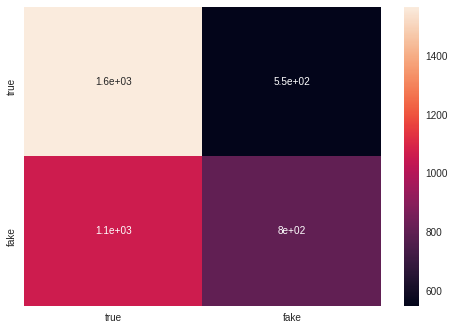

In [134]:
matrix = confusion_matrix(target_or_fake_tgt.argmax(axis=1), pr[:,2:].argmax(axis=1))
print(matrix)

df_cm = pd.DataFrame(matrix, columns=['true', 'fake'], index=['true', 'fake'])
sns.heatmap(df_cm, annot=True)

#### Predicción sobre Getting Real


In [0]:
pred = cnn_model.predict(fit_getting_real)

pr = pred.round()
#Set Bias to Fake
mask = np.all((pred.round() == [1.,0.,0.,0.]), axis=1)
pr[mask] = np.repeat(np.array([0.,0.,1.,0.]).reshape(-1,4), pr[mask].shape[0], axis=0)


#Set target bias to fake
mask = np.all((target_getting_real == [1.,0.,0.]), axis=1)
target_getting_real[mask] = np.repeat(np.array([0.,1.,0.]).reshape(-1,3), target_getting_real[mask].shape[0], axis=0)

In [157]:
accuracy_score(target_getting_real[:,1:], pr[:,2:])

0.4734318817419097

In [158]:
report = classification_report(target_getting_real[:,1:], pr[:,2:])
print(report)

              precision    recall  f1-score   support

           0       0.57      0.66      0.61      1503
           1       0.30      0.19      0.23      1000

   micro avg       0.49      0.47      0.48      2503
   macro avg       0.43      0.43      0.42      2503
weighted avg       0.46      0.47      0.46      2503
 samples avg       0.47      0.47      0.47      2503



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


[[1047  456]
 [ 808  192]]


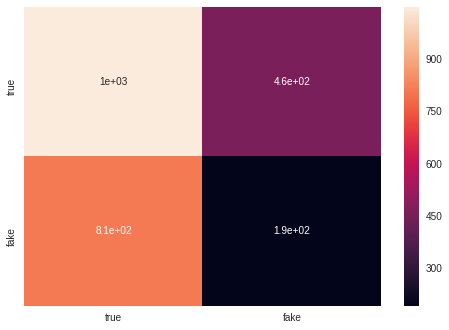

In [160]:
matrix = confusion_matrix(target_getting_real[:,1:].argmax(axis=1), pr[:,2:].argmax(axis=1))
print(matrix)

df_cm = pd.DataFrame(matrix, columns=['true', 'fake'], index=['true', 'fake'])
sns.heatmap(df_cm, annot=True)